In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import PCA
from pandas import read_pickle
import pickle
from keras.models import model_from_json

# test datasets
from toy_data import Two2DGaussians
from toy_data import TwoAlternating2DGaussians
from toy_data import TwoLinearDynamicalSystems
from motion_data import MotionCaptureData
from coffee_shop_world_data import CoffeeShopWorldData

# hack to import model from parent directory
# TODO fix with proper modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
from models import SEM, KerasLDS, LinearDynamicSystem, KerasMultiLayerPerceptron
from models import KerasSimpleRNN, KerasGRU
from opt.utils import evaluate, randstr


Using TensorFlow backend.


In [4]:
# Show summary statistics

res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_None_summary.pkl')


# Test summary results

TL;DR I found no generalization on coffee shop world with default SEM parameters, vanilla HRRs, and little pretraining. Next step: try Jerry's modified HRRs.

## Methods:

I ran Coffee Shop World with pretraining. For each test, I first pretrained SEM with a given number of n_iterations (as defined in the Coffee Shop World engine) with n_repeats = 2 for each iteration, with the poetry and fight schemas. So basically data generated by:

```
python run_engine.py poetry fight [n_iterations] 2
```

So 1 iteration = `[poetry event, fight event, poetry event, fight event]`.

During pretraining, I give the model the correct event labels (e.g. `[0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 ...]`) so it can learn the "correct" event models.

Then I ran this pretrained SEM on a separate data set with n_iterations = 20, i.e. 

```
python run_engine.py poetry fight 20 2
```

I did this separately for different values of n_iterations (and different SEM objects obviously).

I used "vanilla" HRRs, as defined in Tony Plate's paper (without any of the stuff Jerry did). The parameters of each separate run can be found further below.

## Results:

Here I'm plotting how well SEM did depending on how much pretraining it received. Basically, it only did well for n_iterations = 20, which I just realized produces identical pretraining and test data (search below for `pretraining params 20, 2, 400`). So not good.

[0, 2, 4, 8, 10, 20, 40, 80]


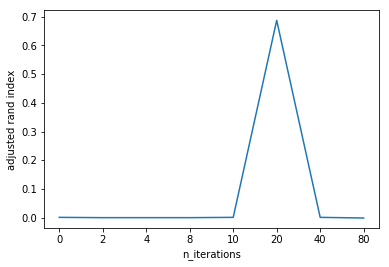

In [28]:
t = res['tests_to_run']

x = [x[1][0] if x[1] else 0 for x in t]

#x[0] = 1
print x
rs = res['rs']
plt.plot(range(len(rs)), rs)
#plt.xscale('log')
plt.xticks(range(len(rs)), x)
plt.xlabel('n_iterations')
plt.ylabel('adjusted rand index')
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400


In [ ]:
# Ensure reproducibility
#
np.random.seed(0)


In [ ]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()


In [ ]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


In [ ]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [ ]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [ ]:
# Alternatively, load results from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_0.pkl')
sem.deserialize(res['sem'])
post = res['post']


In [ ]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


In [ ]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


In [ ]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400 with pretraining


In [ ]:
# Ensure reproducibility
#
np.random.seed(0)


In [ ]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()


In [ ]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()


In [ ]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


In [ ]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [ ]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [ ]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_1_pretrain.pkl')
sem.deserialize(res['sem'])


In [ ]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [ ]:
# Alternatively, load results from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_1.pkl')
sem.deserialize(res['sem'])
post = res['post']


In [ ]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


In [ ]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


In [ ]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400 with pretraining


In [29]:
# Ensure reproducibility
#
np.random.seed(0)


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), 

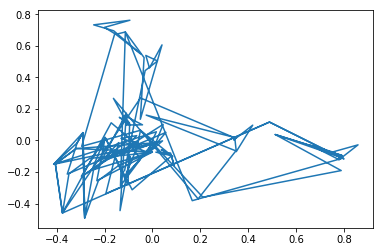

In [30]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(4,2,400)
pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), 

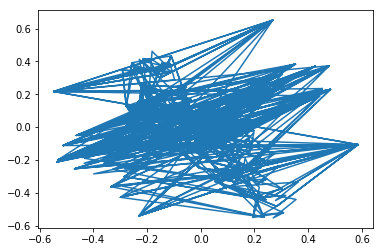

In [31]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()


In [32]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [33]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [34]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [35]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_2_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [ 57.  72.]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_8AMZK53WTS/event_model_weights_M6QDI0UE2Z.h5
       loading event model 1  from  output_8AMZK53WTS/event_model_weights_6IWWP6R7G5.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  7.47811276e-02  -3.31955642e-02  -2.72732702e-02   1.47960401e-02
  -1.71217076e-02  -4.06866434e-02   1.61171631e-02  -7.76041080e-02
   3.28976343e-02   1.24505229e-02  -9.39217430e-03  -7.54433093e-02
   3.67490969e-02   5.19549778e-02  -8.68634720e-02  -1.57316330e-02
   2.83725287e-02  -1.80529038e-0

In [36]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [37]:
# Alternatively, load results from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_2.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  57.  740.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


In [38]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -1.83031722911e-15
Adjusted Rand Score: 0.0

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1

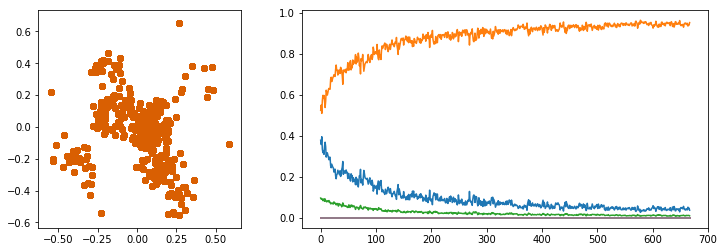

In [39]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


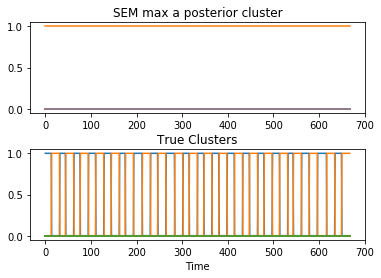

In [40]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400 with pretraining


In [41]:
# Ensure reproducibility
#
np.random.seed(0)


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), 

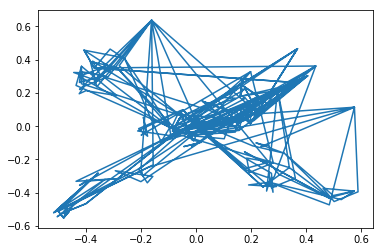

In [42]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(8,2,400)
pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), 

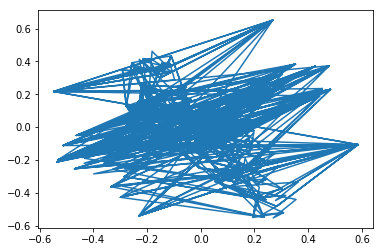

In [43]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()


In [44]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [45]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [46]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [47]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_3_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [ 121.  144.]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_8AMZK53WTS/event_model_weights_6Q2XN0MX91.h5
       loading event model 1  from  output_8AMZK53WTS/event_model_weights_OY1AV4YZD5.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  9.97020794e-03   2.07186759e-03  -2.50752290e-02  -2.02172613e-02
  -5.26291449e-02   7.24328260e-02  -6.40000213e-02  -1.62136987e-02
   4.09611962e-02  -2.57192917e-02  -3.06277320e-03  -3.71900970e-02
   1.02166023e-02   4.89679731e-02  -3.92476427e-02   3.93791585e-02
   5.11498048e-02  -3.04672158e

In [48]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [49]:
# Alternatively, load results from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_3.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [ 121.  812.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


In [50]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -1.83031722911e-15
Adjusted Rand Score: 0.0

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1

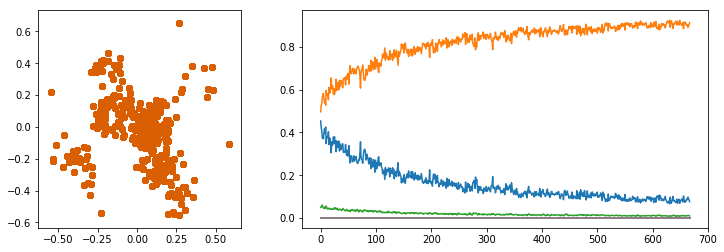

In [51]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


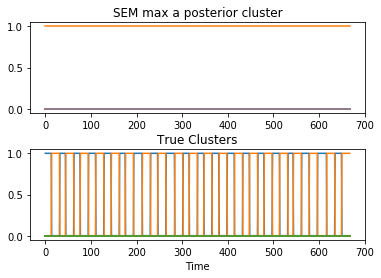

In [52]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400 with pretraining


In [53]:
# Ensure reproducibility
#
np.random.seed(0)


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), 

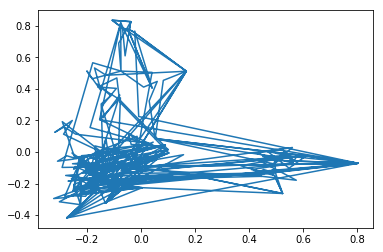

In [54]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(10,2,400)
pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), 

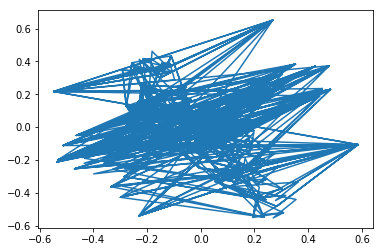

In [55]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()


In [56]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [57]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [58]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [59]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_4_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [ 154.  180.]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_8AMZK53WTS/event_model_weights_TEYJ46812O.h5
       loading event model 1  from  output_8AMZK53WTS/event_model_weights_0RM4Z11KHX.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  1.52993772e-02   2.56229392e-02   1.59257290e-03  -3.27808256e-02
   5.94832164e-02   8.83166738e-02   1.31398583e-02   4.72995952e-02
  -2.27082862e-03   1.03628553e-02   8.40833122e-02  -4.66914745e-03
   9.55141139e-02   1.04474049e-02  -1.00200228e-02   9.99946398e-03
   5.65147695e-02  -2.39987714e

In [60]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [61]:
# Alternatively, load results from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_4.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [ 156.  846.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.


In [ ]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.00186863107511
Adjusted Rand Score: 0.00102886369848

[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 

In [ ]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


In [ ]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400 with pretraining params 20, 2, 400


In [ ]:
# Ensure reproducibility
#
np.random.seed(0)


In [ ]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(20,2,400)
pretrain_data.plot_scenes()


In [ ]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()


In [ ]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


In [ ]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [ ]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [ ]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_5_pretrain.pkl')
sem.deserialize(res['sem'])


In [ ]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [ ]:
# Alternatively, load results from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_5.pkl')
sem.deserialize(res['sem'])
post = res['post']


In [ ]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


In [ ]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


In [ ]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400 with pretraining


In [ ]:
# Ensure reproducibility
#
np.random.seed(0)


In [ ]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(40,2,400)
pretrain_data.plot_scenes()


In [ ]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()


In [ ]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


In [ ]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [ ]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [ ]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_6_pretrain.pkl')
sem.deserialize(res['sem'])


In [ ]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [ ]:
# Alternatively, load results from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_6.pkl')
sem.deserialize(res['sem'])
post = res['post']


In [ ]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


In [ ]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


In [ ]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test CoffeeShopWorldData with params 20, 2, 400 with pretraining


In [ ]:
# Ensure reproducibility
#
np.random.seed(0)


In [ ]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(80,2,400)
pretrain_data.plot_scenes()


In [ ]:
# Load test data
# 
test_data = CoffeeShopWorldData(20,2,400)
test_data.plot_scenes()


In [ ]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


In [ ]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [ ]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [ ]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_7_pretrain.pkl')
sem.deserialize(res['sem'])


In [ ]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [ ]:
# Alternatively, load results from past execution
#
res = read_pickle('output_8AMZK53WTS/test_results_8AMZK53WTS_7.pkl')
sem.deserialize(res['sem'])
post = res['post']


In [ ]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


In [ ]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


In [ ]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()
